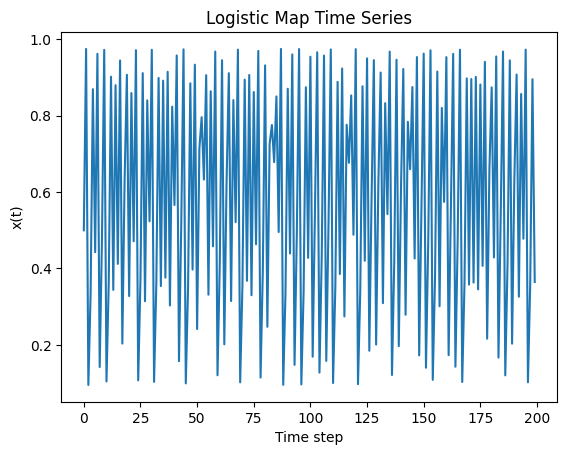

In [6]:
import numpy as np
import matplotlib.pyplot as plt

# Generate a logistic map time series
def logistic_map(r=3.9, x0=0.5, N=1000):
    x = np.zeros(N)
    x[0] = x0
    for i in range(1, N):
        x[i] = r * x[i-1] * (1 - x[i-1])
    return x

ts = logistic_map()
plt.plot(ts[:200])
plt.title("Logistic Map Time Series")
plt.xlabel("Time step")
plt.ylabel("x(t)")
plt.show()


In [30]:
import wfdb
import plotly.graph_objs as go

file = '/Users/weijithwimalasiri/Desktop/JustForFun/RPS/physionet.org/files/afpdb/1.0.0/p47'
record = wfdb.rdrecord(file, sampto=5000, channels=[1])
annotation = wfdb.rdann(file, 'qrs', sampto=5000)
print(annotation.fs)
fig = go.Figure()
fig.add_trace(go.Scatter(y=record.p_signal.flatten(), mode='lines', name='ECG'))
fig.add_trace(go.Scatter(
    x=annotation.sample,
    y=[record.p_signal[i, 0] for i in annotation.sample],
    mode='markers',
    marker=dict(color='red', size=6),
    name='QRS peaks'
))
fig.update_layout(title='ECG Signal', xaxis_title='Sample', yaxis_title='Amplitude')


128


In [41]:
from sklearn.preprocessing import StandardScaler
import numpy as np

def delay_embedding(signal, m, tau):
    N = len(signal)
    if m * tau >= N:
        raise ValueError("Embedding dimension and delay must be chosen such that m * tau < N")
    return np.array([signal[i:i + m * tau:tau] for i in range(N - m * tau)])

# Optional: normalize
m = 8
tau = 11
X_embedded = delay_embedding(record.p_signal.flatten(), m, tau)
# X_embedded = StandardScaler().fit_transform(X_embedded)

In [39]:
from sklearn.metrics import mutual_info_score

# Function to compute average mutual information
# This function bins the signal and computes the mutual information for different lags
# It returns an array of average mutual information values for each lag
# The signal is binned into a specified number of bins to reduce noise and improve the estimation
# The mutual information is computed between the binned signal at different lag
# Find the first local minimum in the AMI curve. That's the tau value that gives the best prediction of the future state of the system.
def bin_signal(x, num_bins = 64):
    hist, bin_edges = np.histogram(x, bins=num_bins)
    return np.digitize(x, bin_edges[:-1])
def average_mutual_information(signal, max_lag =100, num_bins=64):
    x_binned = bin_signal(signal)
    mi = []
    for tau in range(1, max_lag + 1):
        x1 = x_binned[:-tau]
        x2 = x_binned[tau:]
        mi.append(mutual_info_score(x1, x2))
    return np.array(mi)

print(record.p_signal.flatten().shape)
ami = average_mutual_information(record.p_signal.flatten(), max_lag=100, num_bins=64)

fig = go.Figure()
fig.add_trace(go.Scatter(
    x=list(range(1, 101)),
    y=ami,
    mode='lines+markers',
    line=dict(color='royalblue'),
    marker=dict(size=4),
    name='AMI'
))
fig.update_layout(
    title="Average Mutual Information vs Delay",
    xaxis_title="Delay (τ)",
    yaxis_title="Average Mutual Information",
    template="plotly_white",
    xaxis=dict(tickmode='linear'),
    yaxis=dict(showgrid=True),
    width=800,
    height=500
)
fig.show()



(5000,)


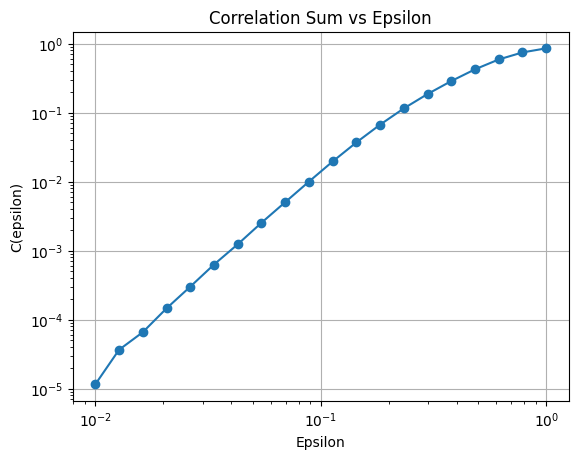

Estimated correlation dimension D2 ≈ 2.652


In [40]:
# Estimate the correlation dimension D2 using the correlation sum method
# The correlation sum method is a technique used to estimate the correlation dimension of a time series.
# It involves calculating the correlation sum for a range of epsilon values and then fitting a line to
# the log-log plot of the correlation sum against epsilon.
# The slope of this line gives an estimate of the correlation dimension D2.
# Accordinmg to the Takens' theorem, if you embed a time series with m >= D2 +1 , then the reconstruction of the attractor is topologically equivalent to the original system.
def correlation_sum(X, epsilons):
    N = len(X)
    D = pdist(X)
    C = []
    for eps in epsilons:
        count = np.sum(D < eps)
        C.append(count / (N * (N - 1) / 2))
    return np.array(C)

epsilons = np.logspace(-2, 0, 20)
C = correlation_sum(X_embedded, epsilons)

plt.loglog(epsilons, C, marker='o')
plt.title("Correlation Sum vs Epsilon")
plt.xlabel("Epsilon")
plt.ylabel("C(epsilon)")
plt.grid(True)
plt.show()

# Estimate D2 from the slope of the log-log plot
from scipy.stats import linregress

log_eps = np.log(epsilons)
log_C = np.log(C)
slope, intercept, *_ = linregress(log_eps[5:-5], log_C[5:-5])
print(f"Estimated correlation dimension D2 ≈ {slope:.3f}")


In [ ]:
from scipy.spatial.distance import pdist, squareform
distances = pdist(X_embedded)
mean_diamter = np.mean(distances)
print(f"Mean diameter of the embedded space: {mean_diamter:.4f}")
maximum_diamter = np.max(distances)
print(f"Maximum diameter of the embedded space: {maximum_diamter:.4f}")
print("Fixed dimension of phase space 1% of the mean diameter:", mean_diamter * 0.01)
print("Fixed dimension of phase space 1% of the maximum diameter:", maximum_diamter * 0.01)


# Choose epsilon s.t. the recurrence rate is specific value 1% or 5%
D = squareform(pdist(X_embedded))
recurrence_matrix = (D < 0.5398).astype(int)
N = recurrence_matrix.shape[0]
recurrence_rate = np.sum(recurrence_matrix) / (N * N)
print(f"Recurrence rate: {recurrence_rate:.4f}")

# Choose epsilon that minimized beta
lmin = 2
def count_diagonal_lines(matrix, lmin):
    count = 0
    N = matrix.shape[0]
    for offset in range(-N + 1, N):
        diag = np.diagonal(matrix, offset=offset)
        length = 0
        for value in diag:
            if value == 1:
                length += 1
            else:
                if length >= lmin:
                    count += 1
                length = 0
        if length >= lmin:
            count += 1
    return count

Np = count_diagonal_lines(recurrence_matrix, lmin)

print(f"Number of diagonal lines with length >= {lmin}: {Np}")

flipped_recurrence_matrix = np.fliplr(recurrence_matrix)

Nn = count_diagonal_lines(flipped_recurrence_matrix, lmin)

print(f"Number of diagonal lines with length >= {lmin} in flipped matrix: {Nn}")

beta = abs(Np - Nn) / (Nn + 0.0001)
print(f"Beta (asymmetry measure): {beta:.4f}")


Mean diameter of the embedded space: 1.1091
Maximum diameter of the embedded space: 3.4338
Fixed dimension of phase space 1% of the mean diameter: 0.011091374142531763
Fixed dimension of phase space 1% of the maximum diameter: 0.03433751592646154
Recurrence rate: 0.0500
Number of diagonal lines with length >= 2: 277781
Number of diagonal lines with length >= 2 in flipped matrix: 317829
Beta (asymmetry measure): 0.1260


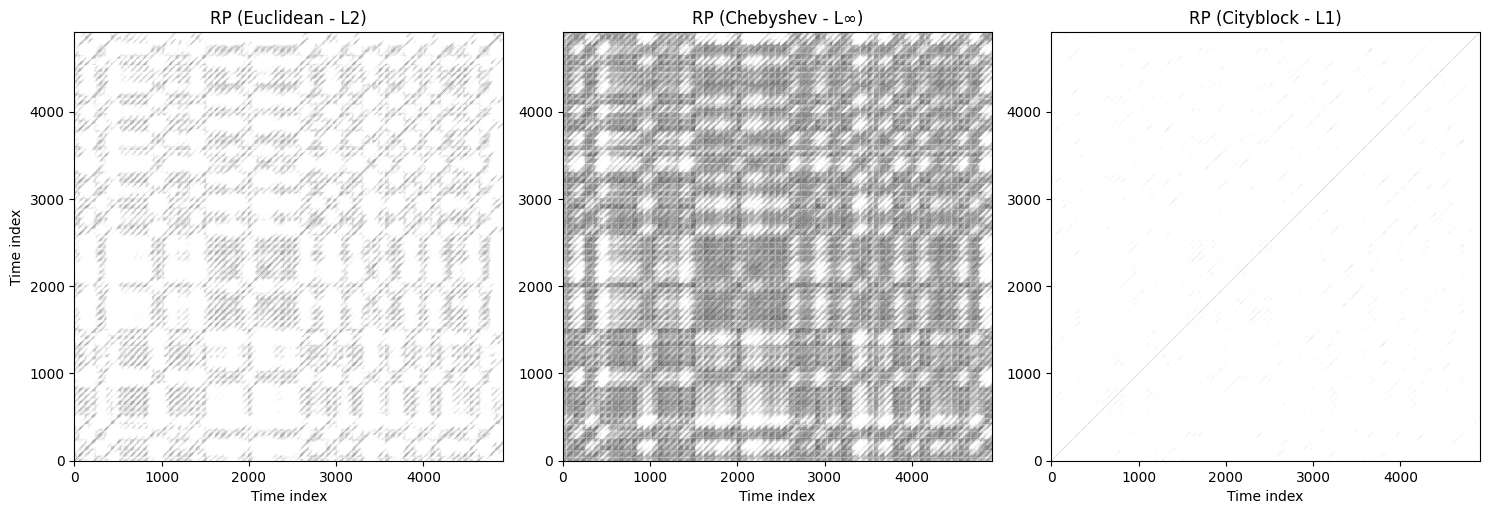

In [86]:
from scipy.spatial.distance import pdist, squareform
import matplotlib.pyplot as plt
def recurrence_plot(X, epsilon, metric='euclidean'):
    D = squareform(pdist(X, metric))  # pairwise distances
    R = (D < epsilon).astype(int)
    return R

# Generate RP
epsilon = 0.5398
R1 = recurrence_plot(X_embedded, epsilon, metric='euclidean')
R2 = recurrence_plot(X_embedded, epsilon, metric='chebyshev')
R3 = recurrence_plot(X_embedded, epsilon, metric='cityblock')

# Plotting all three
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

axs[0].imshow(R1, cmap='binary', origin='lower')
axs[0].set_title("RP (Euclidean - L2)")
axs[0].set_xlabel("Time index")
axs[0].set_ylabel("Time index")

axs[1].imshow(R2, cmap='binary', origin='lower')
axs[1].set_title("RP (Chebyshev - L∞)")
axs[1].set_xlabel("Time index")
axs[1].set_ylabel("")

axs[2].imshow(R3, cmap='binary', origin='lower')
axs[2].set_title("RP (Cityblock - L1)")
axs[2].set_xlabel("Time index")
axs[2].set_ylabel("")

plt.tight_layout()
plt.show()